<center> <h1>Machine Learning Analysis on KDD99 Dataset</h1></center>

## Importing the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [3]:
df = pd.read_csv("C:\\Users\\manig\\Downloads\\kddcup99.csv") #Importing the dataset into a dataframe
df.head() #Printing the first five rows of the dataframe

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [4]:
df.shape #shape prints the number of rows and columns in the dataframe. The dataset has 42 unique features and 494020 samples.

(494020, 42)

## Exploratory data analysis

In [5]:
def expand_categories (values):
    result = []
    s = values.value_counts() 
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v, round(100*(s[v]/t),2))) 
    return "[{}]".format(",".join(result))

def analyze (df):
    cols = df.columns.values 
    total = float(len(df))
    for col in cols:
        uniques=df[col].unique() 
        unique_count = len(uniques)
        if unique_count>100:
            print("===> {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("===> {}:{}".format(col, expand_categories (df[col]))) 
            expand_categories (df[col])

In [6]:
analyze(df) #We are analyzing the data by looking at the unique values present in the dataset by calling analyze() function.

===> duration:2495 (0%)
===> protocol_type:[icmp:57.41%,tcp:38.47%,udp:4.12%]
===> service:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,gopher:0.02%,imap4:0.02%,discard:0.02%,domain:0.02%,iso_tsap:0.02%,systat:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,whois:0.02%,sql_net:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,sunrpc:0.02%,netbios_ssn:0.02%,mtp:0.02%,vmnet:0.02%,uucp_path:0.02%,uucp:0.02%,klogin:0.02%,bgp:0.02%,ssh:0.02%,supdup:0.02%,nnsp:0.02%,login:0.02%,hostnames:0.02%,efs:0.02%,daytime:0.02%,link:0.02%,netbios_ns:0.02%,pop_2:0.02%,ldap:0.02%,netbios_dgm:0.02%,exec:0.02%,http_443:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,pm_dump:0.0%,tftp_u:0.0%,red_i:0.0%]
===> flag:[SF:76.6%,S0:17.61%,REJ:5.44%,RSTR:0.18%,RSTO:0.12%,SH:0.02%,S1:0.0

For example, the duration column has 2495 unique values, and there is a 0% overlap. We have displayed the percentage of the unique value in the column if the number of unique values is less than 100 to save display space. This is done by the expand_categories() function. For example, a text or categorical feature such as protocol_type only has a few unique values, and the program shows the percentages of each category.

In [7]:
df.isna().sum().sum() #Checking whether there are any null values or not. We dont have any null values

0

## Data Prepprocessing

In [8]:
def zscore_normalization(df, col): 
    mean =df[col].mean() 
    sd=df[col].std()
    df[col] = (df[col] - mean) / sd
    
def one_hot_encoding(df, col):
    dummies_column= pd.get_dummies(df[col]) 
    for x in dummies_column.columns: 
        dummy_name = f"{col}-{x}"
        df [dummy_name] = dummies_column[x] 
    df.drop(col, axis=1, inplace=True)

#Z - Score normalization is done using zscore_normalization() function and one hot encoding is done by one_hot_encoding().

In [9]:
for col in df.columns:
    if col == "label":
        pass
    elif col in ["protocol_type", "service", "flag"]: 
        one_hot_encoding(df, col) #In this dataset, we have text data in protocol_type, service and flag. So we are using one hot encoding to convert text to numerical input.
    else:
        zscore_normalization(df, col) #We have different ranges of input we should normalize it. We are normalizing the data using Z - Score because we know the range of the values. This is why we are not going to any other normalizing methods.

In [10]:
df.dropna(inplace=True, axis=1) #Dropping the records which have null values.

In [11]:
x_columns_name = df.columns.drop('label')
x = df[x_columns_name].values #Storing independent features in x by dropping the target feature

In [12]:
x

array([[-0.06779172, -0.00287853,  0.13866418, ...,  0.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00281984, -0.0115778 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00282388,  0.01417884, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.06779172, -0.00285627,  0.01003235, ...,  0.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00276722,  0.01003235, ...,  0.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00284007,  0.01106141, ...,  0.        ,
         1.        ,  0.        ]])

In [13]:
x.shape #x has 494020 samples and 116 features

(494020, 116)

In [14]:
dummies_variable = pd.get_dummies(df['label']) #Creating dummy variables for target feature - label (Similar to one hot encoding)
outcomes = dummies_variable.columns
y = dummies_variable.values #Storing the created dummy variables in a variable named y.

In [15]:
y.shape #y has 494020 samples and 23 features which has to be predicted. It has 23 features because that column had 23 different classes.

(494020, 23)

In [16]:
x.shape

(494020, 116)

In [17]:
df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.067792,-0.002879,0.138664,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,...,0,0,0,0,0,0,0,0,1,0
1,-0.067792,-0.002820,-0.011578,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,...,0,0,0,0,0,0,0,0,1,0
2,-0.067792,-0.002824,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,...,0,0,0,0,0,0,0,0,1,0
3,-0.067792,-0.002840,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,...,0,0,0,0,0,0,0,0,1,0
4,-0.067792,-0.002842,0.035214,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,...,0,0,0,0,0,0,0,0,1,0


In [18]:
df.shape #The dataset after preprocessing has 116 features + 1 target variable (totally 117) and 494020 samples.

(494020, 117)

<AxesSubplot:>

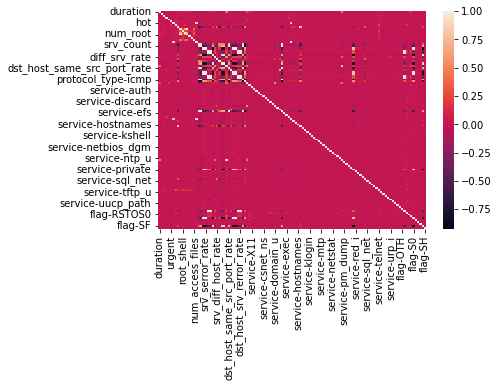

In [19]:
sns.heatmap(df.corr()) #Printing the heatmap based on correlation value
#From the heatmap which is derived based on correlation between two features, we can see that there are no two features which has high correlation. So, we dont want to drop any columns as of now.

## Splitting the dataset

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
#We are splitting the dataset into train data (75% and test data (25%).

## ANN Model

In [74]:
#Since we have a classification problem, we can't choose any other neural netork model such as CNN (which is mainly used for image processing) etc. This is the main reason to choose ANN for this problem.
model = Sequential()
model.add(Dense(64, input_dim=x.shape[1], activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense (32, kernel_initializer='normal'))
model.add(Dense (y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=10)

Epoch 1/10
11579/11579 [==============================] - 44s 4ms/step - loss: 0.0183 - accuracy: 0.9968 - val_loss: 0.0095 - val_accuracy: 0.9982
Epoch 2/10
11579/11579 [==============================] - 45s 4ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 3/10
11579/11579 [==============================] - 46s 4ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0051 - val_accuracy: 0.9990
Epoch 4/10
11579/11579 [==============================] - 45s 4ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0050 - val_accuracy: 0.9991
Epoch 5/10
11579/11579 [==============================] - 44s 4ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 6/10
11579/11579 [==============================] - 49s 4ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 7/10
11579/11579 [==============================] - 51s 4ms/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 0

We developed an artificial neural network which is sequential. We added one input layer with 116 neurons since we have 116 input features, four hidden layers with ReLU as activation layer with 64 or 32 neurons and one output layer with softmax as activation layer with 23 neurons because we have 23 classes (which is derived after applying one hot encoding on the target variable). We have used adam optimizer to reduce the loss and categorical_crossentropy as a cost function to calculate the loss.
<br>We are also validating in each epoch with test data. The accuracy and loss in each epoch are calculated using training dataset and val_accuracy and val_loss is calculated based on test dataset which is basically validation process.

In [75]:
loss_acc_ann = model.evaluate(x_test, y_test)
print("Accuracy of ANN Model "+ str(loss_acc_ann[1]))
print("Loss of ANN Model "+ str(loss_acc_ann[0]))
#We have got an accuracy of 99.920% which is really good for an ANN model and a loss value of 0.837% which is really low and its negligible.

3860/3860 [==============================] - 9s 2ms/step - loss: 0.0084 - accuracy: 0.9992
Accuracy of ANN Model 0.9992064833641052
Loss of ANN Model 0.008373276330530643


In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7488      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 23)                759       
                                                                 
Total params: 15,543
Trainable params: 15,543
Non-trainable params: 0
_________________________________________________________________


## Decision Tree Model (Before Optimization)

#### Reason for choosing Decision Tree and Random Forest model
We didn’t use Naïve Bayes and Logistic Regression because we have used one hot encoding on target variable and we have 23 columns at the end which makes it difficult to fit into the algorithm and we avoided KNN algorithm because of its very high runtime. We will have very high runtime because it’s a Lazy predictor and we have many columns and 370515 samples in training dataset which increases the runtime exponentially. <br>
The only left options are Decision Tree and Random forest tree algorithm. These algorithms are really efficient for classfication probelms which made us to choose them. So, we have chosen Decision Tree and Random forest tree algorithm for this classification problem.

#### Training steps
First, we train the model using the sci-kit library. <br>
Second, we are printing the classification matrix which tells about recall, accuracy, precision and f1-score for each target variable and the average of the above mentioned scores also.<br>
Third, we are printing the confusion matrix of Precited Vs Truth values of target variables. <br>
Fourth, we are printing the accuracy of the model. <br>
(This applies for all models and Inference of each model has been mentioned at the end)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       540
           1       0.86      0.50      0.63        12
           2       0.25      1.00      0.40         1
           3       1.00      0.80      0.89        10
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00       326
           6       1.00      0.71      0.83         7
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     26664
          10       0.95      1.00      0.97        52
          11       1.00      1.00      1.00     24282
          12       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         0
          14       0.98      0.98      0.98        49
          15       1.00      0.99      1.00       275
          16       0.00      0.00      0.00         2
          17       0.99    

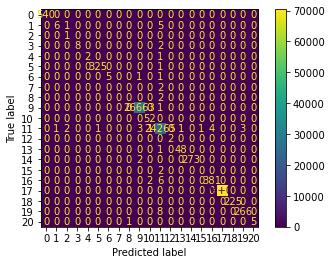

Accuracy of Decision Tree Model is 0.9995465770616574


In [21]:
int_model1 = DecisionTreeClassifier()
int_model1 .fit(x_train,y_train) #Training the model
acc = int_model1.score(x_test, y_test) #Storing the sccuuracy score in acc variable
y_predict = int_model1.predict(x_test) #Predicting the ouutput for x_test  using the trained model
print(classification_report(y_test, y_predict)) #Printing the classification matrix which tells about recall, accuracy, precision and f1-score for each target variable
confusionMatrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
cm_display.plot()
plt.show() #Printing the confusion matrix
print("Accuracy of Decision Tree Model is "+str(acc)) #Printing the accuracy of the model

#### We got an accuracy of 99.9514% and we can also see recall, precision and f1 score for decision tree model.

## Random Forest Model (Before Optimization)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       540
           1       1.00      0.50      0.67        12
           2       1.00      1.00      1.00         1
           3       1.00      0.80      0.89        10
           4       1.00      0.67      0.80         3
           5       0.99      0.99      0.99       326
           6       1.00      0.71      0.83         7
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     26664
          10       1.00      0.96      0.98        52
          11       1.00      1.00      1.00     24282
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         0
          14       1.00      0.98      0.99        49
          15       1.00      0.99      0.99       275
          16       0.00      0.00      0.00         2
          17       1.00    

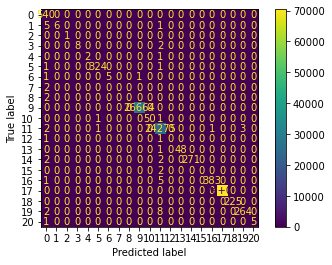

Accuracy of Random Forest Model is 0.9995789644143962


In [32]:
int_model2 = RandomForestClassifier()
int_model2 .fit(x_train,y_train) #Training the model
acc = int_model2.score(x_test, y_test) #Storing the sccuuracy score in acc variable
y_predict = int_model2.predict(x_test) #Predicting the ouutput for x_test using the trained model
print(classification_report(y_test, y_predict)) #Printing the classification matrix which tells about recall, accuracy, precision and f1-score for each target variable
confusionMatrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
cm_display.plot()
plt.show() #Printing the confusion matrix
print("Accuracy of Random Forest Model is "+str(acc)) #Printing the accuracy of the model

#### We have got an accuracy of 99.9578% and we can also see recall, precision and f1 score for the random forest model.

## Feature Extraction (Optimization)

#### We are optimizing the model by extracting the important features since we might have many unwanted features which doesn’t contribute in classification and those might mislead the model.
#### For feature extraction, we are exploiting a feature available in decision tree algorithm. The decision tree library provides a feature to calculate importance of each feature while training the model.

In [77]:
feature_ext = DecisionTreeClassifier()
feature_ext.fit(x,y) #Training a decision tree model on the whole dataset without splitting
imp = feature_ext.feature_importances_ #Using feature_importance_ feature to get importance of each feature and we are storing inn imp variable.

In [78]:
imp #Printing the importance of each feature

array([1.00453825e-04, 6.79255985e-03, 1.11480110e-04, 3.85286740e-05,
       6.19540286e-03, 3.09711692e-06, 1.65871419e-03, 2.85231827e-04,
       3.46931129e-05, 1.29906872e-02, 1.38884636e-05, 5.99352888e-06,
       7.43233090e-06, 5.78966952e-05, 6.73887154e-06, 1.12777130e-05,
       1.31231273e-04, 1.01816821e-04, 6.04769507e-01, 6.23263644e-05,
       0.00000000e+00, 4.94789801e-05, 6.39309747e-06, 3.26143831e-01,
       2.95600276e-04, 1.82711820e-05, 5.46200277e-04, 1.80420686e-04,
       3.51052843e-05, 1.17391294e-02, 1.34517444e-03, 7.21931410e-03,
       1.04356924e-04, 6.31915239e-03, 3.02969822e-04, 0.00000000e+00,
       4.06696694e-05, 1.02331073e-05, 9.63483204e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.93876209e-04, 5.18271951e-04, 0.00000000e+00, 0.00000000e+00,
      

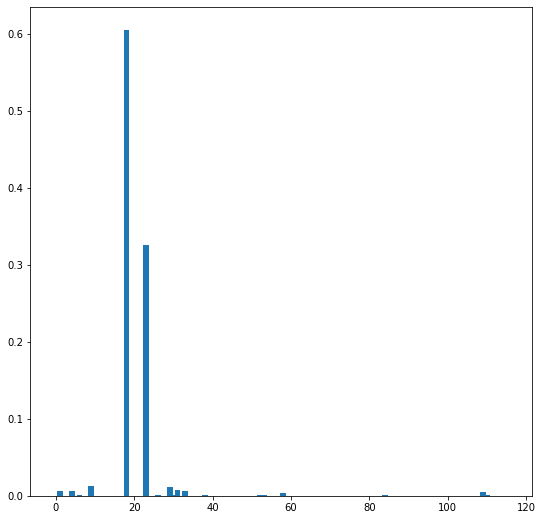

In [79]:
plt.figure(figsize=(9,9))
plt.bar([x for x in range(len(imp))], imp, width=1.5)
plt.show() #Showing the importance of each feature in bar chart

In [80]:
unwanted_cols = []
for i,j in enumerate(imp):
    if(j<0.001): #We are checking for the features which has importance value less than 0.001.
        unwanted_cols.append(i) #If its less than 0.001 we will append coluumn number in a list which will be later used to drop those columns in the list.
unwanted_feat = len(unwanted_cols)
print("There are "+str(unwanted_feat)+" unwanted features.")

There are 104 unwanted features.


In [81]:
print(unwanted_cols) #Printing the unwanted column numbers.

[0, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115]


In [82]:
x = np.delete(x, [2, 3, 5, 8, 10, 11, 12, 13, 14, 15, 19, 20, 22, 25, 28, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 115], axis=1)
#We are removing the unwanted features which has importance less than 0.001.

In [83]:
x

array([[-0.06779172, -0.00287853, -0.04772019, ...,  0.        ,
         0.        ,  1.        ],
       [-0.06779172, -0.00281984, -0.04772019, ...,  0.        ,
         0.        ,  1.        ],
       [-0.06779172, -0.00282388, -0.04772019, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.06779172, -0.00285627, -0.04772019, ...,  0.        ,
         0.        ,  1.        ],
       [-0.06779172, -0.00276722, -0.04772019, ...,  0.        ,
         0.        ,  1.        ],
       [-0.06779172, -0.00284007, -0.04772019, ...,  0.        ,
         0.        ,  1.        ]])

In [84]:
x.shape #We have 28 features at the end.

(494020, 28)

## Randomized Search CV  (Optimization)

#### For hyperparameter tuning, in order to automate this process of trying different combinations of hyperparameters, we will be using Randomized Search CV.

In [86]:
model_params = {
    'Decision Tree' : {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10, 50, 100, 200, 300, 400, 500],
            'criterion': ['gini', 'entropy', 'log_loss'],
        }
    }

}

#We created a JSON object which contains the models along with the parameters which we will be using to train the model which will be used for Randomized Search CV.

## Training models using Randomized Search CV (After Optimization)

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) #We are again splitting the dataset into train data (75% and test data (25%) because we have applied feature extraction previously on the original dataframe.

In [96]:
scores1 = [] #List to store model name, best training score, parameters that gave the best accuracy and accuracy of the model.

for model_name, mp in model_params.items(): #We are inputting the JSON object to RandomizedSearchCV() which trains each of the model in JSON using for loop with different combination of parameters.
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False) #We have user K-fold cross validation value as 3 because we have 370515 samples. In this line, the RandomizedSearchCV selects the model and parameters to train and store in clf model.
    clf.fit(x_train, y_train) #The selected model along with parameters are trained
    scores1.append({ #Appending model name, best training score, parameters that gave the best accuracy and accuracy of the model in a list.
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'accuracy' : clf.score(x_test, y_test)
    })
    
acc1 = pd.DataFrame(scores1,columns=['model','best_score','best_params', 'accuracy']) #Converting the list into dataframe for easy interpretation.
acc1 #Printing the dataframe containing model name, best training score, parameters that gave the best accuracy and accuracy of the model.

,model,best_score,best_params,accuracy
0,Decision Tree,0.999609,"{'splitter': 'best', 'criterion': 'entropy'}",0.999619
1,Random Forest,0.999641,"{'n_estimators': 200, 'criterion': 'entropy'}",0.999628


#### After training using Randomized Search CV, we can see that we are getting an accuracy of 99.9641% for Random Forest model and 99.9609% for Decision tree model which is higher than the non-optimized models which was 99.9578% for Random Forest model and 99.9514% for Decision Tree model. Even though the difference/increase in accuracy between optimized and non-optimized model, is less, we have still improved the model by applying optimization methods like feature extraction and hyperparameter tuning using Randomized Search CV.

## Evaluation metrics

Evaluation metrics:
1. Accuracy Score
2. Recall score

The reason for recall score as one of evaluation metric is because we need the model to classify the network flow correctly rather than giving false positives and false negatives. Recall score calculates the efficiency of the model based on true positives. This is why we chose recall score as one of our evaluation metric. The reason for choosing accuracy score is to calculate the overall efficieny of the model. <br>
<b>For recall score, we got 1 (weighted average) for both the models. So accuracy score will be the main deciding factor.<b>

## Conclusion
After optimizing the models using Feature extraction and Hyper parameter tuning, we get a highest accuracy of 99.9641% for Random Forest model and 99.9609% for Decision tree model. So, we can conclude that Random Forest model gives the highest accuracy when comparing both the models with the parameters: n_estimators: 200 and criterion: entropy and therefore it’s the best model.
Thus, for detecting cyber attacks. Random Forest is the best model which can used by training on the above mentioned parameters using KDD99 dataset.